# PAMTRA example on airborne measurements and ICON-LEM data

Here we give an example on how to use PAMTRA for a comparison between airborne measured radar reflectivities and brightness temperatures and modeled quantities. The application of such a task can be an evaluation of the cloud resolving model ICON-LEM by airborne measurements. In contrast to the example shown in the PAMTRA publication, we only show the simulations and results for one ICON simulation.

The example requires some input data in the data folder that can be downloaded from University of Cologne:

  * [ICON data](https://uni-koeln.sciebo.de/s/XHMxsXVd1a9yuy9) (13 MB)
  * [MiRAC observations](https://uni-koeln.sciebo.de/s/4kbbArtm9V9qzH9) (7 MB)


Start with importing the required libraries and setting up the Notebook to show plots inline.

In [1]:
import numpy as np
import pyPamtra

Define the hydrometeor description for the six hydrometeors of the ICON-LEM microphysical scheme.

In [2]:
descriptorFile = np.array([
        #['hydro_name' 'as_ratio' 'liq_ice' 'rho_ms' 'a_ms' 'b_ms' 'alpha_as' 'beta_as' 'moment_in' 'nbin' 'dist_name' 'p_1' 'p_2' 'p_3' 'p_4' 'd_1' 'd_2' 'scat_name' 'vel_size_mod' 'canting']
        ('cwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   2.0,    1.0,   2.0e-6,   8.0e-5, 'mie-sphere', 'corPowerLaw_24388657.6_2.0', -99.0),
        ('iwc_q', 1.0, -1, -99.0, 1.58783,  2.56,  0.684,   2.0, 13, 100, 'mgamma', -99.0, -99.0, 1.564, 0.8547, 1.744e-5, 9.369e-3, 'ssrg-rt3',   'corPowerLaw_30.606_0.5533',  -99.0),
        ('rwc_q', 1.0,  1, -99.0,   -99.0, -99.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   2.0,    1.0,  0.00012,   8.2e-3, 'mie-sphere', 'corPowerLaw_494.74_0.7031',  -99.0),
        ('swc_q', 0.6, -1, -99.0,   0.038,   2.0, 0.3971,  1.88, 13, 100, 'mgamma', -99.0, -99.0,   1.0,    1.0,  5.13e-5, 2.294e-2, 'ssrg-rt3',   'corPowerLaw_5.511054_0.25',  -99.0),
        ('gwc_q', 1.0, -1, -99.0,  500.86,  3.18,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,  5.37,   1.06,  2.11e-4,   1.3e-2, 'mie-sphere', 'corPowerLaw_406.67_0.85',    -99.0),
        ('hwc_q', 1.0, -1, -99.0,  392.33,   3.0,  -99.0, -99.0, 13, 100, 'mgamma', -99.0, -99.0,   5.0,    1.0,  1.87e-4,   1.1e-2, 'mie-sphere', 'corPowerLaw_106.33_0.5',     -99.0)],
        dtype=[('hydro_name', 'S15'), ('as_ratio', '<f8'), ('liq_ice', '<i8'), ('rho_ms', '<f8'), ('a_ms', '<f8'), ('b_ms', '<f8'), ('alpha_as', '<f8'), ('beta_as', '<f8'), ('moment_in', '<i8'), ('nbin', '<i8'), ('dist_name', 'S15'), ('p_1', '<f8'), ('p_2', '<f8'), ('p_3', '<f8'), ('p_4', '<f8'), ('d_1', '<f8'), ('d_2', '<f8'), ('scat_name', 'S20'), ('vel_size_mod', 'S30'), ('canting', '<f8')] 
        )

In [3]:
iconFile = 'data/acloud_icon_input.nc'

In [4]:
pam = pyPamtra.importer.readIcon2momOnFlightTrack(iconFile, descriptorFile)

/home/mech/lib/python/pyPamtra/core.py:823: Warning: timestamp set to now
  warnings.warn("timestamp set to now", Warning)
/home/mech/lib/python/pyPamtra/core.py:840: Warning: wind10u set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:840: Warning: wind10v set to 0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:840: Warning: groundtemp set to nan
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:840: Warning: sfc_salinity set to 33.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:840: Warning: sfc_slf set to 1.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:840: Warning: sfc_sif set to 0.0
  warnings.warn("%s set to %s"%(environment,preset,), Warning)
/home/mech/lib/python/pyPamtra/core.py:850: Warning: sfc_type 

In [5]:
pam.p['sfc_type'] = np.zeros(pam._shape2D)
pam.p['sfc_model'] = np.zeros(pam._shape2D)
pam.p['sfc_refl'] = np.chararray(pam._shape2D)
pam.p['sfc_refl'][pam.p['sfc_type'] == 0] = 'F'
pam.p['obs_height'][:,0] = 3000.

Set up everything for the active calculation.

In [6]:
pam.nmlSet['radar_attenuation'] = 'top-down' # include attenuation by gas and hydrometeors

In [7]:
pam.nmlSet['passive'] = False # switch off passive calculations

Now run PAMTRA for 94 GHz in parallel mode by making chunks of 10 profiles in x direction (pp_deltaX=10) and using all available cores (pp_local_workers="auto").

In [8]:
pam.runParallelPamtra(94.,pp_deltaX=10, pp_deltaY=1, pp_deltaF=1, pp_local_workers="auto")

Define output file and store active results to it.

In [9]:
outFileAct = 'data/pamtra_icon_active.nc'

In [10]:
pam.writeResultsToNetCDF(outFileAct)

Set up everything for passive calculation.

In [11]:
pam.nmlSet['passive'] = True
pam.nmlSet['active'] = False

Run PAMTRA in parallel mode for 89 GHz passive to produce brightness temperatures.

In [12]:
pam.runParallelPamtra(89.,pp_deltaX=10, pp_deltaY=1, pp_deltaF=1, pp_local_workers="auto")

Define output file and store results for later usage.

In [13]:
outFilePas = 'data/pamtra_icon_passive.nc'

In [14]:
pam.writeResultsToNetCDF(outFilePas)

In [15]:
import pickle #  load pickle module to read the mirac data

In [16]:
with open('data/mirac.pkl', 'rb') as input:
    Ze, tb, lon, alt = pickle.load(input)

Use the pyPamtra.importer.ncToDict() module to read passive and active results again.

In [17]:
pamp = pyPamtra.importer.ncToDict('data/pamtra_icon_passive.nc')

opening 1 of 1 data/pamtra_icon_passive.nc


In [18]:
pama = pyPamtra.importer.ncToDict('data/pamtra_icon_active.nc')

opening 1 of 1 data/pamtra_icon_active.nc


Import plotting modules and set up inline plotting. 

In [19]:
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

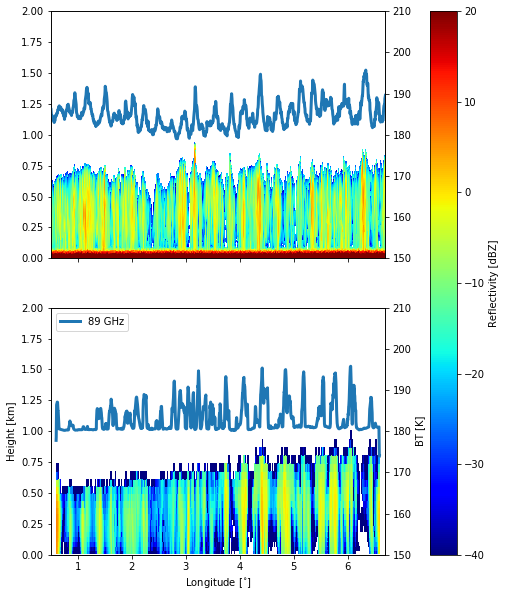

In [21]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), sharex=True)
pm = axes[0].pcolormesh(lon,alt/1.e3,10.*np.log10(Ze.T),vmin=-40.,vmax=20.,cmap='jet', rasterized=True)
ax1tb = axes[0].twinx()
ax1tb.plot(lon, tb,lw=3)
ax1tb.set_ylim([150,210])

axes[0].set_ylim([0.,2.])

longitude = np.zeros((pama['longitude'].shape[0],pama['height'].shape[2]))
longitude = np.repeat(pama['longitude'],pama['height'].shape[2],axis=1)
pc = axes[1].pcolormesh(longitude[:,:],pama['height'][:,0,:]/1.e3,pama['Ze'][:,0,:,0,0,0],vmin=-40.,vmax=20.,cmap='jet')

axes[1].set_ylim([0.,2.])
ax2tb = axes[1].twinx()

ax2tb.plot(pama['longitude'],pamp['tb'][:,0,0,4,0,1],lw=3,label='89 GHz')

ax2tb.legend(loc='upper left')
ax2tb.axis('tight')
ax2tb.set_ylim([150,210])
ax2tb.set_ylabel('BT [K]')

axes[1].set_xlim([0.5,6.7])
ax2tb.set_xlim([0.5,6.7])
axes[1].set_ylabel('Height [km]')
axes[1].set_xlabel('Longitude [$^{\circ}$]')

plt.colorbar(pc, ax=axes.ravel().tolist(), label='Reflectivity [dBZ]', pad=0.1)